In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import Image

import matplotlib as mpl
#mpl.rcParams.update({'font.size': 10})

%matplotlib nbagg

In [2]:
def sin(theta):
    return np.sin(theta*np.pi/180.)

def cos(theta):
    return np.cos(theta*np.pi/180.)

## Load RIXS

In [3]:
with open('120meV_exchange/RIXS_pol_11_out.spec') as fin:
    header = [fin.readline() for n in range(4)]

num_spectra = int(header[0][:-1].split(' ')[-1])
Emin1, Emax1 = -7., -3.
E1 = np.linspace(Emin1, Emax1, num_spectra)

file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(1, 1)
data = np.loadtxt(file_name, skiprows=5)
E2 = data[:,0]
RIXSmap = data[:,2::2]

In [4]:
def get_rixs(out_pol, in_pol):
    cutrow = 300

    file_name = 'zero_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap0 = -data[:,2::2]
    
    file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap120 = -data[:,2::2]
    
    RIXSmap = np.vstack((RIXSmap120[:cutrow], RIXSmap0[cutrow:]))
    
    return RIXSmap

pol_iter = [(out_pol, in_pol) for out_pol in range(3) for in_pol in range(3)]
RIXSmaps = [get_rixs(out_pol+1, in_pol+1) for out_pol, in_pol in pol_iter]

## Get XAS

In [5]:
XAS = sum(RIXSmaps).sum(axis=0)
#fig, ax = plt.subplots()
#ax.plot(E1, XAS, '.-')
Eres = E1[np.argmax(XAS)]
print('Resonance at {:.3f}'.format(Eres))

Resonance at -5.200


## Get spectra

In [6]:
spectra = [RIXSmap[:,np.argmax(XAS)] for RIXSmap in RIXSmaps]

spectra_matrix = np.zeros((len(E2), 3, 3))
for spectrum, (in_pol, out_pol) in zip(spectra, pol_iter):
    spectra_matrix[:, in_pol, out_pol] = spectrum

maxval = np.max(spectra_matrix)

## Define functions

In [7]:
def norm(v):
    """Normalize vector v"""
    return v/np.sqrt((v**2).sum())

def make_a(k, kp, in_pol):
    """Construct the absoprtion vector from the indicent and scattered k vectors"""
    sigma = np.cross(k, kp)
    if in_pol == 'sigma':
        return norm(sigma)
    elif in_pol == 'pi':
        pi = np.cross(k, sigma)
        return norm(pi)
    else:
        raise(Exception("""In_pol incorrectly specificed"""))

def make_e(k, kp):
    """Construct the emission vector from the indicent and scattered k vectors"""
    sigma = np.cross(k, kp)
    pi = np.cross(sigma, kp)
    combined = np.sqrt(sigma**2 + pi**2)
    return norm(combined)

def rot_mat(u, phi):
    """Returns matrix that rotates by angle phi about axis u"""
    R = np.array([[cos(phi) + u[0]**2*(1-cos(phi)),
                  u[0]*u[1]*(1-cos(phi)) - u[2]*sin(phi), 
                  u[0]*u[2]*(1-cos(phi)) + u[1]*sin(phi)],

                 [u[1]*u[0]*(1-cos(phi)) + u[2]*sin(phi),  
                  cos(phi) + u[1]**2 *(1-cos(phi)),
                  u[1]*u[2]*(1-cos(phi)) -u[0]*sin(phi)],

                 [u[2]*u[0]*(1-cos(phi)) - u[1]*sin(phi),
                  u[2]*u[1]*(1-cos(phi)) + u[0]*sin(phi),
                  cos(phi) + u[2]**2 *(1-cos(phi))]
                 ])
    return R

def get_orbital_ints_azi(k_i, kp_i, u, phi, in_pol):
    spectrum = get_spectrum(k_i, kp_i, u, phi, in_pol)
    return get_energies(spectrum)

def get_spectrum(k_i, kp_i, u, phi, in_pol):
    """Get spectrum for for initial incident and scattered vectors k_i & kp_i
    after rotating by phi about axis u"""
    R = rot_mat(u, phi)
    k = np.matmul(R, k_i)
    kp = np.matmul(R, kp_i)
        
    absorption_pol = make_a(k, kp, in_pol)
    emitted_pol = make_e(k, kp)
        
    M = np.outer(emitted_pol, absorption_pol)
    M = np.abs(M)
    spectrum = (M*spectra_matrix).sum(axis=(1,2))
    
    return spectrum

def get_energies(spectrum):
    mag = np.interp(0.238, E2, spectrum)
    z = np.interp(1.68, E2, spectrum)
    xy = np.interp(1.79, E2, spectrum)
    xz = np.interp(2.10, E2, spectrum)
    
    return mag, z, xy, xz

## Compute azimuth for incident x-rays along c-axis

<IPython.core.display.Javascript object>


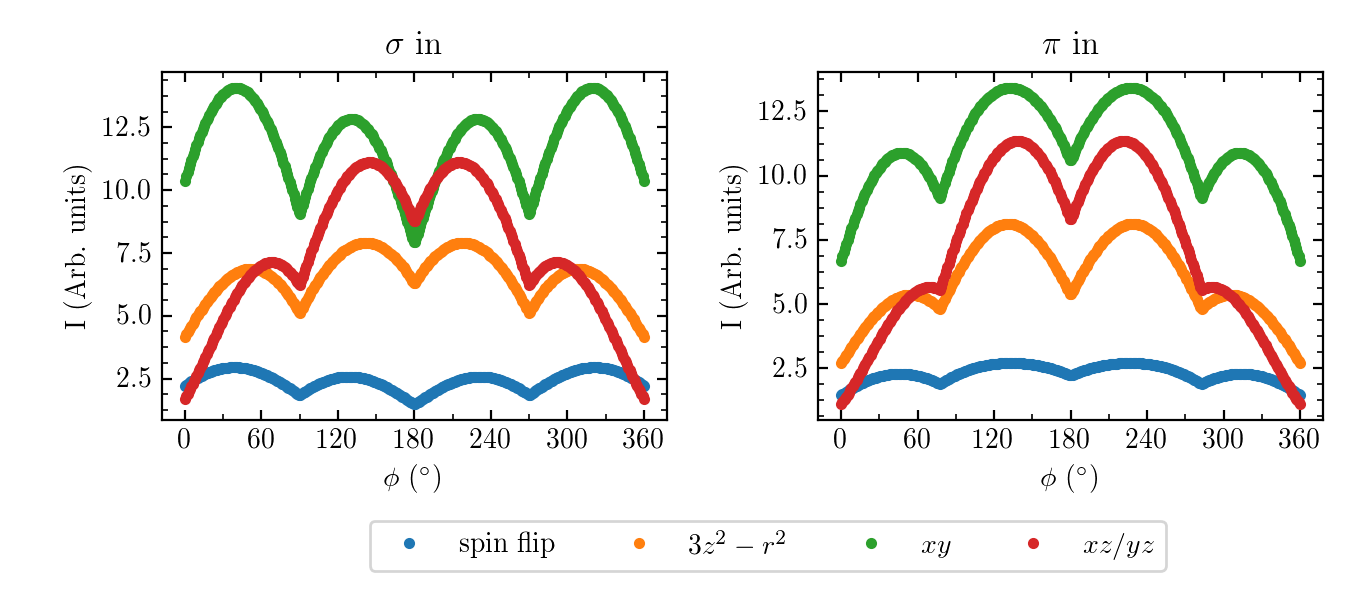

In [8]:
tth = 130
th_i = 40
th_o = 90
Q_ang = th_i + (180-tth)/2

k_i = np.array([cos(th_i), 0, sin(th_i)]) # starting incoming k vector
kp_i = np.array([0, 0, 1])                # starting incoming k vector
u = np.array([cos(Q_ang), 0, sin(Q_ang)]) # rotating about this Q vector

phis = np.linspace(0, 360, 360)
intensities_sigma = np.array([get_orbital_ints_azi(k_i, kp_i, u, phi, 'sigma') for phi in phis])
intensities_pi = np.array([get_orbital_ints_azi(k_i, kp_i, u, phi, 'pi') for phi in phis])

fig, axs = plt.subplots(1,2, figsize=(6+3/4,3))

for ax, intensities, title in zip(axs, [intensities_sigma, intensities_pi], ['$\sigma$ in', '$\pi$ in']):
    if np.any(np.isnan(intensities)):
        print("Intensities {}".format(intensities))
        print("error here")
    ax.plot(phis, intensities[:,0], '.', label='spin flip')
    ax.plot(phis, intensities[:,1], '.',label='$3z^2-r^2$')
    ax.plot(phis, intensities[:,2], '.',label='$xy$')
    ax.plot(phis, intensities[:,3], '.',label='$xz/yz$')

    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(30))
    ax.set_title(title)
    ax.set_xlabel('$\phi$ ($^{\circ}$)')
    ax.set_ylabel('I (Arb. units)')

axs[1].legend(loc=9, bbox_to_anchor=(-0.1, -0.25), ncol=4)

fig.subplots_adjust(bottom=0.3, left=0.12, right=0.98, wspace=0.3)
fig.savefig('azimuthal.pdf')

Outgoing beam is along c
phi zero has 100 in scattering plane